The following code was executed on jupyter notebook under Python 3.7


In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
print('TF version',tf.__version__)

TF version 2.3.0


In [ ]:
vocab_file_path = 'vocab-roberta-base.json'
merges_file_path = 'merges-roberta-base.txt'
train_path = 'train.csv'
test_path  = 'test.csv'

In [ ]:
import tokenizers
MAX_LENGTH = 96
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file_path, 
    merges_file_path, 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv(train_path).fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
#train = train[0:100]

In [ ]:
def text_tokenizer(shape,first_coloumn,last_coloumn):
    
    for k in range(shape):
        # FIND OVERLAP
        # selects the text coloum from training set for each row iteration eg K=1-> first row
        text1 = " "+" ".join(train.loc[k,first_coloumn].split())
        # selects the Selected_text coloum from training set for each row iteration eg K=1-> first row
        text2 = " ".join(train.loc[k,last_coloumn].split())
        # returns the index where the selected text is within the original text
        index = text1.find(text2)
        # makes a array of zeros which is the same length as the selected text
        characters = np.zeros((len(text1)))
        #adds 1 to the array position form the start index till the end of the selected text
        characters[index:index+len(text2)]=1
        # if there is a space before the start of the index add one to that position
        if text1[index-1]==' ': characters[index-1] = 1 
        #encodes the text using tokenizer
        encoding = tokenizer.encode(text1) 
        
        # Calculate ID_OFFSETS for the text
        offsets = []; index=0
        for t in encoding.ids:
            #for each id in encoded text decode it
            w = tokenizer.decode([t])
            # id decoded to palintext and then add the length of the token to 
            # offsets give a tuple where consisting of id where each token starts and ends
            # This is required for the next part of finding start and end tokens
            offsets.append((index,index+len(w)))
            index += len(w)

        # START END TOKENS
        tokens = []
        for i,(a,b) in enumerate(offsets):
            sm = np.sum(characters[a:b])
            if sm>0: tokens.append(i) 
        
        sentiments_token = sentiment_id[train.loc[k,'sentiment']]
        text_input_ids[k,:len(encoding.ids)+5] = [0] + encoding.ids + [2,2] + [sentiments_token] + [2]
        token_attention_mask[k,:len(encoding.ids)+5] = 1
        if len(tokens)>0:
            start_tokens[k,tokens[0]+1] = 1
            end_tokens[k,tokens[-1]+1] = 1

In [ ]:
training = train.shape[0]
#declare numpy arrays for all the inputs within for the model suchs as tokens attention mask etc.
text_input_ids= np.ones((training,MAX_LENGTH),dtype='int32')
token_attention_mask = np.zeros((training,MAX_LENGTH),dtype='int32')
token_type_ids = np.zeros((training,MAX_LENGTH),dtype='int32')
start_tokens = np.zeros((training,MAX_LENGTH),dtype='int32')
end_tokens = np.zeros((training,MAX_LENGTH),dtype='int32')

In [ ]:
text_tokenizer(train.shape[0],'text','selected_text')

In [ ]:
test = pd.read_csv(test_path).fillna('')
#test = test[0:100]

#tokenise the text in test file 
testing = test.shape[0]
text_input_ids_testing = np.ones((testing,MAX_LENGTH),dtype='int32')
attention_mask_t = np.zeros((testing,MAX_LENGTH),dtype='int32')
token_type_ids_t = np.zeros((testing,MAX_LENGTH),dtype='int32')

for k in range(test.shape[0]):
        
    text1 = " "+" ".join(test.loc[k,'text'].split())
    encoding = tokenizer.encode(text1)                
    sentiment_token = sentiment_id[test.loc[k,'sentiment']]
    text_input_ids_testing[k,:len(encoding.ids)+5] = [0] + encoding.ids + [2,2] + [sentiment_token] + [2]
    attention_mask_t[k,:len(encoding.ids)+5] = 1

In [ ]:
from transformers import RobertaConfig
from transformers import RobertaModel
from transformers import TFRobertaModel

In [ ]:
#function to build the roBERTa model
def build_model():
    ids = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    attention = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    tokens = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained('config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained('pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=attention,token_type_ids=tokens)
    
    #outputs form each layers are fed to the next layer
    layer1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    layer1 = tf.keras.layers.Conv1D(1,1)(layer1)
    layer1 = tf.keras.layers.Flatten()(layer1)
    layer1 = tf.keras.layers.Activation('softmax')(layer1)
    
    layer2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    layer2 = tf.keras.layers.Conv1D(1,1)(layer2)
    layer2 = tf.keras.layers.Flatten()(layer2)
    layer2 = tf.keras.layers.Activation('softmax')(layer2)

    model = tf.keras.models.Model(inputs=[ids, attention, tokens], outputs=[layer1,layer2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [ ]:
#function to calculate similiarities between the test for evalution phase
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
from transformers import RobertaConfig

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth= True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
jac = []; DISPLAY=1 
test_start = np.zeros((text_input_ids.shape[0],MAX_LENGTH))
test_end = np.zeros((text_input_ids.shape[0],MAX_LENGTH))
preds_start = np.zeros((text_input_ids_testing.shape[0],MAX_LENGTH))
preds_end = np.zeros((text_input_ids_testing.shape[0],MAX_LENGTH))

#split the traing into training and validation 
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=777)
for (indexTraining,indexValidation) in skf.split(text_input_ids,train.sentiment.values):
    
    K.clear_session()
    model = build_model()

    #save the weights of the model in the local directory   
    sv = tf.keras.callbacks.ModelCheckpoint(
        'roberta-model.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')

    #train the model on base on input token attention masks, token_type_ids and start/end tokens     
    model.fit([text_input_ids[indexTraining,], token_attention_mask[indexTraining,], token_type_ids[indexTraining,]], [start_tokens[indexTraining,], end_tokens[indexTraining,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([text_input_ids[indexValidation,],token_attention_mask[indexValidation,],token_type_ids[indexValidation,]], 
        [start_tokens[indexValidation,], end_tokens[indexValidation,]]))
    
    print('Model load')
    model.load_weights('roberta-model.h5')
    
    #predict for validation set
    print('Predict Val')
    test_start[indexValidation,],test_end[indexValidation,] = model.predict([text_input_ids[indexValidation,],token_attention_mask[indexValidation,],token_type_ids[indexValidation,]],verbose=DISPLAY)

      
    print('Predict Test class')
    preds = model.predict([text_input_ids_testing,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    #get jaccard score for test data
    all = []
    for k in indexValidation:
        a = np.argmax(test_start[k,])
        b = np.argmax(test_end[k,])
        if a>b: 
            st = train.loc[k,'text'] 
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> Jaccard mean =',np.mean(all))
    print()

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f7bd89691d8> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f7bd89691d8> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1/3
430/430 [==============================] - ETA: 0s - loss: 2.4502 - activation_loss: 1.2072 - activation_1_loss: 1.2430WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated 

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
430/430 [==============================] - ETA: 0s - loss: 2.3813 - activation_loss: 1.1730 - activation_1_loss: 1.2083WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).

Epoch 00001: val_loss improved from inf to 1.70770, saving model to roberta-model.h5
430/430 [==============================] - 2785s 6s/step - loss: 2.3813 - activation_loss: 1.1730 - activation_1_loss: 1.2083 - val_loss: 1.7077 - val_activation_loss: 0.8883 - val_activation_1_loss: 0.8194
Epoch 2/3
430/430 [==============================] - ETA: 0s - loss: 1.7130 - activation_loss: 0.8770 - activation_1_loss: 0.8360
Epoch 00002: val_loss improved from 1.70770 to 1.63787, saving model to roberta-model.h5
430/430 [==============================] - 2850s 7s/step - loss: 1.7130 - activation_loss: 0.8770

In [ ]:
print('>>>> OVERALL Jaccard =',np.mean(jac))

>>>> OVERALL Jaccard = 0.7044752885294949


In [ ]:
#convert outputs of the prediction to text which will be save into a csv file
all = []
for k in range(text_input_ids_testing.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('Model_results.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

,textID,text,sentiment,selected_text
776,4e7fb463e0,"Thx, Robban http://www.sk-gaming.com/match/17905",positive,"thx,"
224,be33b5cb9a,Again working on the internet shop ... don`t think we wi...,neutral,again working on the internet shop ... don`t think we w...
905,2a83e56667,"_ really!? that son of a ****, screw him, ill talk to on...",negative,"_ really!? that son of a ****, screw him, ill talk to on..."
353,065e4c2dba,well even with her breakdown she was better than the ot...,negative,unfortunately!
2155,291b817092,I`m feel deflated. Ugh. No more dog.,negative,i`m feel deflated.
761,6872aea3a9,where is home??,neutral,where is home??
1389,8255b23e72,I`m not ready for my baby to be 3 tomorrow she is growi...,positive,she is growing so fast....
190,e131c496a2,Meeting my best friend first thing in the morning to the...,neutral,meeting my best friend first thing in the morning to th...
2805,a4ab64c15c,"'Graverobber, graverobber, sometimes I wonder why I eve...",positive,have fun
96,c238c4dbb7,i just watched Marley & Me...i cried so hard!,negative,i cried so hard!


# **REFERNCES**

**DEPENDENCIES** https://huggingface.co/transformers/_modules/transformers/configuration_roberta.html

https://huggingface.co/transformers/_modules/transformers/tokenization_roberta.html

https://huggingface.co/transformers/pretrained_models.html

https://huggingface.co/transformers/v1.1.0/_modules/pytorch_transformers/tokenization_roberta.html


**PROCESSING** 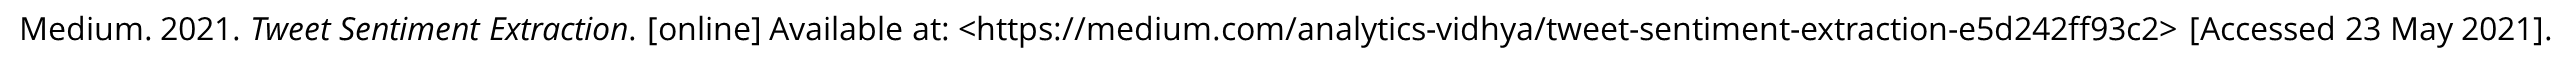

**MODEL CREATION** 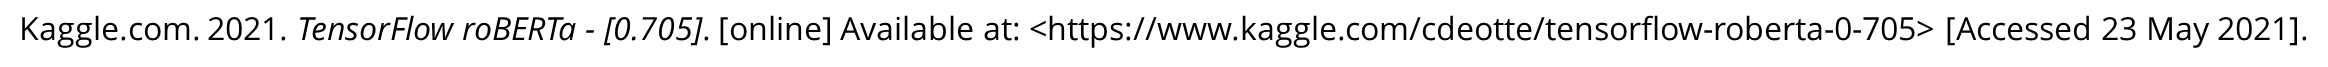


https://stackoverflow.com/questions/18037184/how-to-save-a-csv-to-a-local-directory-in-python